In [3]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='cmpt733project-acc5de89927c.json'
from google.cloud import bigquery
import pandas as pd
import pyarrow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import f1_score

np.random.seed(123)

In [9]:
bigquery_client = bigquery.Client()
### ENTER SQL DATE as ---> YYYYMMDD format ###

In [10]:
QUERY2 = """
SELECT 
*
from `gdelt-bq.gdeltv2.events`
where Year>=2000 and Year<=2020
and (Actor1Name='AFRICA' or Actor1Name='CANADA' or Actor1Name='UNITED STATES' or Actor1Name='CHINA')
limit 100000
"""
# gdelt-bq.gdeltv2.events ### OR ### gdelt-bq.gdeltv2.gkg

In [ ]:
# query_job = bigquery_client.query(QUERY2)
df = (
    bigquery_client.query(QUERY2)
    .result()
    .to_dataframe()
)

In [53]:
# df.to_csv('GDELT20yrs.csv')
# df = pd.read_csv('GDELT20yrs.csv') 

In [54]:
data = df
data = data.iloc[:,1:-1]

In [55]:
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')
data = data.drop(['Actor1KnownGroupCode','Actor1EthnicCode','Actor1Type3Code'],axis=1)

In [56]:
data = data[['SQLDATE','Year','IsRootEvent','QuadClass','NumMentions','NumSources','NumArticles',
             'AvgTone','GoldsteinScale','Actor1Geo_Type','Actor1Geo_Lat','Actor1Geo_Long','Actor2Geo_Type','Actor2Geo_Lat',
             'Actor2Geo_Long','ActionGeo_Type','ActionGeo_Lat','ActionGeo_Long']]
data = data.dropna()
X = data.drop("GoldsteinScale",1)   #Feature Matrix
y = data["GoldsteinScale"] # Target variable

In [57]:
import mchmm as mc  # markovChain-HiddenMarkovModel library
import pandas as pd

d1 = data
d1.ActionGeo_Type.replace([1,2,3,4,5], ['A','B','C','D','E'], inplace=True)
# replace by letters for markov chain sequencing
d1['ActionGeo_Type']

15       D
16       A
17       D
18       A
19       A
        ..
99995    A
99996    A
99997    B
99998    B
99999    A
Name: ActionGeo_Type, Length: 63221, dtype: object

In [ ]:
# markov chain for sequence of events ---> 'ActionGeo_Type' feature to get the type of events observed
# types are -> 1,2,3,4,5
# where -> 
"""
1=no impact, 
2=low impact, 
3=medium impact, 
4=high impact, 
5=violent event
"""

In [59]:
a = mc.MarkovChain().from_data(d1['ActionGeo_Type'])

In [60]:
a.observed_matrix  # observed transition frequency matrix

array([[10152.,   692.,   695.,  1542.,    46.],
       [  672., 12121.,  2288.,   495.,     8.],
       [  691.,  2242., 18003.,   851.,    12.],
       [ 1580.,   518.,   802.,  9406.,    85.],
       [   33.,    11.,    11.,    96.,   168.]])

In [61]:
a.observed_p_matrix  # observed transition probability matrix

array([[0.77336787, 0.05271578, 0.05294431, 0.11746781, 0.00350423],
       [0.04312115, 0.77778491, 0.14681725, 0.03176335, 0.00051335],
       [0.0316987 , 0.10284875, 0.82586357, 0.03903849, 0.00055048],
       [0.1275119 , 0.04180454, 0.0647244 , 0.75909935, 0.00685982],
       [0.10344828, 0.03448276, 0.03448276, 0.30094044, 0.52664577]])

In [62]:
graph = a.graph_make(
      format="png",
      graph_attr=[("rankdir", "LR")],
      node_attr=[("fontname", "Sans bold"), ("fontsize", "20")],
      edge_attr=[("fontname", "Sans bold"), ("fontsize", "12")]
    )

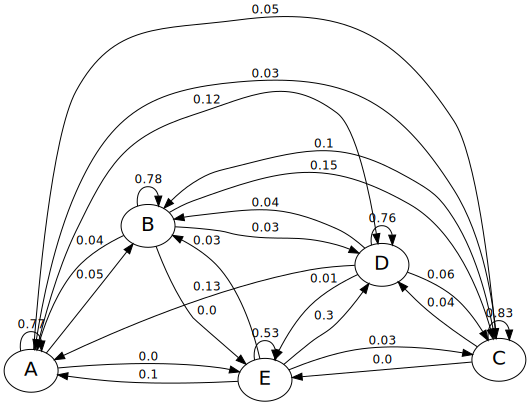

In [63]:
graph  #  can visualize your Markov chain

In [64]:
pd.DataFrame(a.observed_matrix, index=a.states, columns=a.states, dtype=int) # pandas format of markov chain

,A,B,C,D,E
A,10152,692,695,1542,46
B,672,12121,2288,495,8
C,691,2242,18003,851,12
D,1580,518,802,9406,85
E,33,11,11,96,168


In [65]:
ids, states = a.simulate(10, start='A', seed=np.random.randint(0, 10, 10)) # simulating a Markov chain given the data

In [66]:
ids

array([0, 2, 1, 3, 3, 0, 0, 0, 1, 1])

In [67]:
states

array(['A', 'C', 'B', 'D', 'D', 'A', 'A', 'A', 'B', 'B'], dtype='<U1')

In [68]:
"".join(states)  # Simulated Markov chain 

'ACBDDAAABB'

In [ ]:
!pip install pomegranate

In [24]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy

import pomegranate
from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

In [91]:
d1 = DiscreteDistribution({'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}) # initialize with equal probability
d2 = DiscreteDistribution({'A': 0.04, 'B': 0.15, 'C': 0.15, 'D': 0.13, 'E': 0.53}) # graph simulation probabilities

In [92]:
s1 = State(d1, name='IS') # INITIAL STATE
s2 = State(d2, name='EvS') # EVENT SEQUENCE

In [93]:
model = HiddenMarkovModel()
model.add_states(s1, s2)

In [94]:
model.add_transition(model.start, s1, 0.5)
model.add_transition(model.start, s2, 0.5)
model.add_transition(s1, s1, 0.9)
model.add_transition(s1, s2, 0.1)
model.add_transition(s2, s1, 0.1)
model.add_transition(s2, s2, 0.9)

In [95]:
model.bake()  #  to finalize the internal structure of hmm

In [96]:
print(model.to_json())

{
    "class" : "HiddenMarkovModel",
    "name" : "None",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "dtype" : "str",
                "name" : "DiscreteDistribution",
                "parameters" : [
                    {
                        "A" : 0.04,
                        "B" : 0.15,
                        "C" : 0.15,
                        "D" : 0.13,
                        "E" : 0.53
                    }
                ],
                "frozen" : false
            },
            "name" : "EvS",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
  

In [97]:
simulated_seq = numpy.array(list('ACBDDAAABB')) 
random_seq = numpy.array(list('AEEAEEAEACEEECECADC'))

hmm_sim_pred = model.predict(simulated_seq)
hmm_rand_pred = model.predict(random_seq)

print("HMM Demo: \n")
print("Simulated Markov Chain sequence: {}".format(''.join(simulated_seq)))
print("hmm pred for Simulated Sequence: {}".format(''.join(map( str, hmm_sim_pred))),"\n")

print("Random sequence: {}".format(''.join(random_seq)))
print("hmm pred for Random Sequence: {}".format(''.join(map( str, hmm_rand_pred))))

HMM Demo: 

Simulated Markov Chain sequence: ACBDDAAABB
hmm pred for Simulated Sequence: 1111111111 

Random sequence: AEEAEEAEACEEECECADC
hmm pred for Random Sequence: 1001001110000001111


In [98]:
print(model.predict_proba(simulated_seq)[1:])  # transition probabilities for the states in the Simulated sequence

[[0.06096483 0.93903517]
 [0.05592209 0.94407791]
 [0.04379965 0.95620035]
 [0.02962074 0.97037926]
 [0.00997081 0.99002919]
 [0.00826728 0.99173272]
 [0.0189055  0.9810945 ]
 [0.07688521 0.92311479]
 [0.13797337 0.86202663]]


In [99]:
print(model.predict_proba(random_seq)[1:6])  # transition probabilities for the states in the Random sequence

[[0.50708342 0.49291658]
 [0.53326834 0.46673166]
 [0.44379938 0.55620062]
 [0.55187557 0.44812443]
 [0.54092948 0.45907052]]


In [100]:
"""
using the forward-backward algorithm to just calculate posterior probabilities for each observation, 
we can count the number of transitions that are predicted to occur between the hidden states
"""
trans_sim, ems_sim = model.forward_backward(simulated_seq)
print(trans_sim)
 
trans_rand, ems_rand = model.forward_backward(random_seq)
print(trans_rand)

[[0.22393482 0.14000678 0.         0.        ]
 [0.21837466 8.41768375 0.         0.        ]
 [0.05960548 0.94039452 0.         0.        ]
 [0.         0.         0.         0.        ]]
[[7.82874056 1.29201391 0.         0.        ]
 [1.19899047 7.68025505 0.         0.        ]
 [0.33669777 0.66330223 0.         0.        ]
 [0.         0.         0.         0.        ]]


In [107]:
for sequence in map( list, ('ACBDDAAABB', 'CCE', 'EEAC', 'AAACBB') ):
    logp, path = model.viterbi( sequence )
    print("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

Sequence: 'ACBDDAAABB'  -- Log Probability: -17.735770945821383 -- Path: IS IS IS IS IS IS IS IS IS
Sequence: 'CCE'  -- Log Probability: -5.33298645408333 -- Path: EvS EvS
Sequence: 'EEAC'  -- Log Probability: -7.394981082159444 -- Path: EvS EvS EvS
Sequence: 'AAACBB'  -- Log Probability: -10.876577233453677 -- Path: IS IS IS IS IS


In [112]:

def path_to_alignment( x, y, path ):
    """
    To take two sequences, and insert dashes appropriately to make them appear aligned. 
    """
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name 
        if name.startswith( 'A' ):
            y = y[:i] + '-' + y[i:]
        elif name.startswith( 'I' ):
            x = x[:i] + '-' + x[i:]
    return x, y

for sequence in map( list, ('A', 'DA', 'AC', 'AE', 'AECC', 'ACEDB', 'ABBB') ):
    logp, path = model.viterbi( sequence ) # applying viterbi algorithm to get the possible seq
    x, y = path_to_alignment( 'ACDEEC', ''.join(sequence), path )
    print("Sequence: {}, Log Probability: {}".format( ''.join(sequence), logp ))
    print("{}\n{}".format( x, y ))
    print()

Sequence: A, Log Probability: -2.3025850929940455
ACDEEC
A

Sequence: DA, Log Probability: -4.017383521085972
-ACDEEC
DA

Sequence: AC, Log Probability: -4.017383521085972
-ACDEEC
AC

Sequence: AE, Log Probability: -4.017383521085972
-ACDEEC
AE

Sequence: AECC, Log Probability: -7.446980377269825
---ACDEEC
AECC

Sequence: ACEDB, Log Probability: -9.16177880536175
----ACDEEC
ACEDB

Sequence: ABBB, Log Probability: -7.446980377269825
---ACDEEC
ABBB

